# BERT MODEL

In this notebook, we are going to work our way around with the BERT Optimizer Transformer which is essentially a great model (being a transformer) for sentence predictions. 

 BERT's bidirectional prowess allows it to grasp the full context of a sentence, making it adept at understanding the nuances of language. Its meticulous attention to word order adds another layer of sophistication, making it a ninja at capturing subtle meanings. The secret sauce? Pretraining on a vast chunk of internet text, giving BERT an insider's perspective on internet culture, lingo, and memes. In a nutshell, BERT is our language superhero, with bidirectionality, attention to detail, and internet savvy making it the perfect ally for sniffing out toxicity in our online realms

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/ml_proj/'

Mounted at /content/drive


Importing our pathways for Loading our dataframes

In [5]:
import pandas as pd
import numpy as np

# data_train = pd.read_csv('drive/MyDrive/ml_proj/train.csv')
# data_test = pd.read_csv('drive/MyDrive/ml_proj/test.csv')
# test_labels = pd.read_csv('drive/MyDrive/ml_proj/test_labels.csv')
#Defining Some Constant Values
TRAIN = 'train.csv'
TEST = 'test.csv'
TEST_LABEL = 'test_labels.csv'
PROC_DATA = 'processed_train.csv'
PROC_TEST = 'processed_test.csv'

Reading the dataframes

In [6]:
data_train = pd.read_csv(TRAIN)
data_test = pd.read_csv(TEST)
test_label = pd.read_csv(TEST_LABEL)
processed_train = pd.read_csv(PROC_DATA)
processed_test = pd.read_csv(PROC_TEST)
processed_train.describe()

,Unnamed: 0,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.00000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,79785.00000,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,46064.32424,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39892.50000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,79785.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,119677.50000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,159570.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Checking for a potential GPU runtime

In [9]:
import torch
import torch.optim as optim
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's start by looking at the type of words we want our Tranformer to classify correctly

Toxic comment:



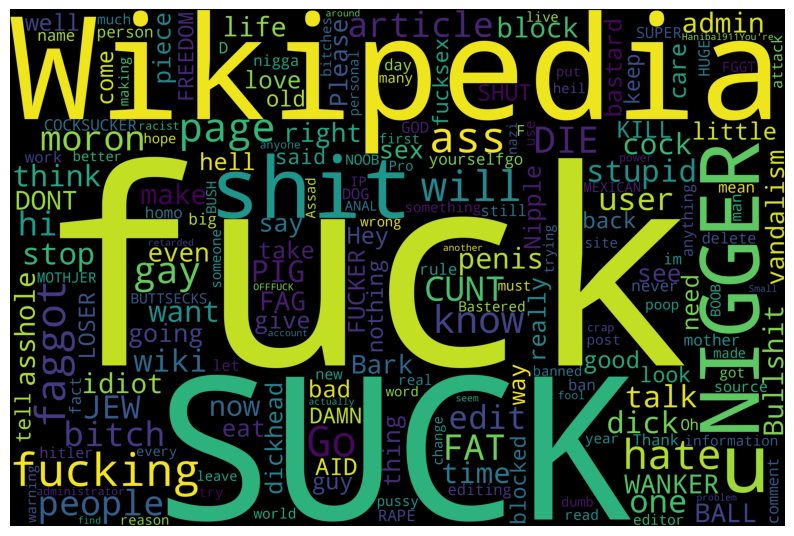


threat comment:



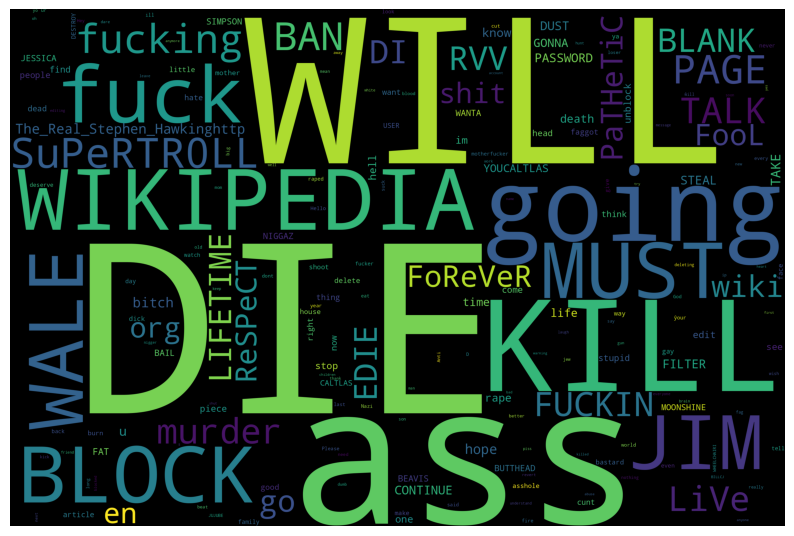

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

toxic_corpus = data_train.loc[data_train['toxic'] == 1]
toxic_corpus = toxic_corpus["comment_text"].tolist()

threat_corpus = data_train.loc[data_train['threat'] == 1]
threat_corpus = threat_corpus["comment_text"].tolist()


print("Toxic comment:")
print()
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(toxic_corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1)
plt.axis("off");
plt.show()

print()
print("threat comment:")
print()
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(threat_corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1)
plt.axis("off");
plt.show()

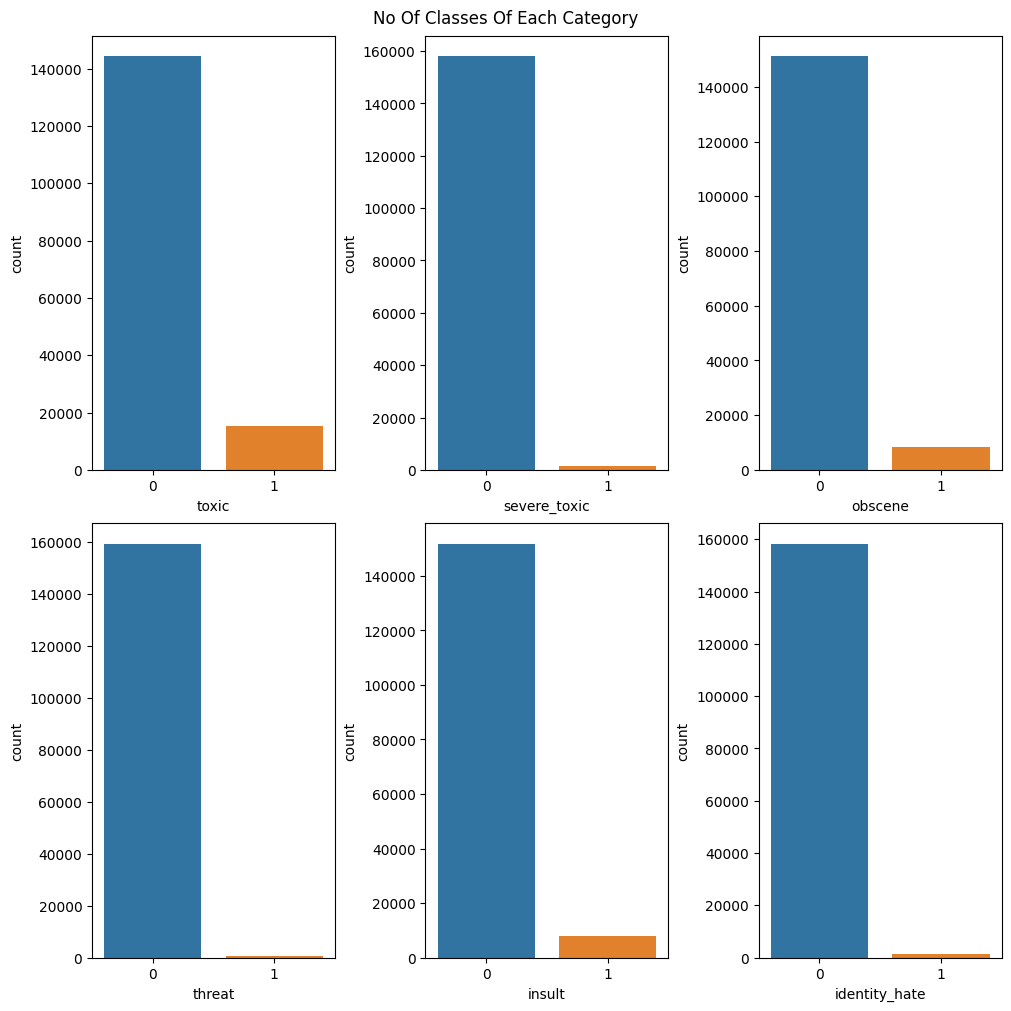

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='toxic',data=processed_train )
sns.countplot(ax=axes[0,1],x='severe_toxic',data=processed_train)
sns.countplot(ax=axes[0,2],x='obscene',data=processed_train)
sns.countplot(ax = axes[1,0],x='threat',data=processed_train)
sns.countplot(ax=axes[1,1],x='insult',data=processed_train)
sns.countplot(ax=axes[1,2],x='identity_hate',data=processed_train)
plt.suptitle('No Of Classes Of Each Category')
plt.show()

Let us start by cleaning our dataset by processing all the sentences our model has to use.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

process_train=data_train.copy(deep=True)
process_test=data_test.copy(deep=True)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def isNaN(string):
    return string != string

def text_processing(text):

  text = re.sub(r'[0-9]+',' ', text) #remove all digits
  text=re.sub(r'[^\x00-\x7f]',' ',text) #removes non ascii
  text=text.lower() #lower case
  text= re.sub('http[s]?://\S+', ' ', text) #remove links
  text = re.sub(r'[^\w\s]+',' ',text) #remove punctuations and special characters
  tokens=word_tokenize(text) #tokenizer
  tokens=[word for word in tokens if word not in stop_words] #remove stop words
  tokens=[word for word in tokens if word.isalnum()]#second pass for punctuation and special characters removal
  tokens=[lemmatizer.lemmatize(word) for word in tokens] #lemmatization of word tokens
  text=' '.join(tokens)


  if isNaN(text) or text=='':
    return 'empty'

  return text

process_train['comment_text']=process_train['comment_text'].apply(text_processing)
process_test['comment_text']=process_test['comment_text'].apply(text_processing)
process_train.to_csv('processed_train.csv')
process_test.to_csv('processed_test.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Load processed data so we donot have to pre-process it again
processed_train = pd.read_csv('processed_train.csv')
processed_test = pd.read_csv('processed_test.csv')


In [19]:
#Importing valuable libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from torch import cuda
import torch
import os
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Next, let's tokenize the text using BERT's tokenizer and create PyTorch datasets:



In [13]:
# Adjust this according to your actual column names
X = processed_train['comment_text']
Y = processed_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Tokenize the input text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = str(self.comments.iloc[idx])
        label = torch.tensor(self.labels.iloc[idx].tolist(), dtype=torch.float32)

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }
    

#Please ignore the outputs as they were done in Google Colab where the engine downloaded stop words and configurations which are unfortunately not displayable.

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
# Define your training and validation datasets
train_dataset = CustomDataset(comments=X_train, labels=Y_train, tokenizer=tokenizer, max_len=128)
val_dataset = CustomDataset(comments=X_val, labels=Y_val, tokenizer=tokenizer, max_len=128)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

This is the info about our Classifier

In [ ]:
# BertForSequenceClassification(
#   (bert): BertModel(
#     (embeddings): BertEmbeddings(
#       (word_embeddings): Embedding(30522, 768, padding_idx=0)
#       (position_embeddings): Embedding(512, 768)
#       (token_type_embeddings): Embedding(2, 768)
#       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
#       (dropout): Dropout(p=0.1, inplace=False)
#     )
#     (encoder): BertEncoder(
#       (layer): ModuleList(
#         (0-11): 12 x BertLayer(
#           (attention): BertAttention(
#             (self): BertSelfAttention(
#               (query): Linear(in_features=768, out_features=768, bias=True)
#               (key): Linear(in_features=768, out_features=768, bias=True)
#               (value): Linear(in_features=768, out_features=768, bias=True)
#               (dropout): Dropout(p=0.1, inplace=False)
#             )
#             (output): BertSelfOutput(
#               (dense): Linear(in_features=768, out_features=768, bias=True)
#               (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
#               (dropout): Dropout(p=0.1, inplace=False)
#             )
#           )
#           (intermediate): BertIntermediate(
#             (dense): Linear(in_features=768, out_features=3072, bias=True)
#             (intermediate_act_fn): GELUActivation()
#           )
#           (output): BertOutput(
#             (dense): Linear(in_features=3072, out_features=768, bias=True)
#             (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
#             (dropout): Dropout(p=0.1, inplace=False)
#           )
#         )
#       )
#     )
#     (pooler): BertPooler(
#       (dense): Linear(in_features=768, out_features=768, bias=True)
#       (activation): Tanh()
#     )
#   )
#   (dropout): Dropout(p=0.1, inplace=False)
#   (classifier): Linear(in_features=768, out_features=6, bias=True)
# )

Training the Model and Evaluating it for 3 Iterations.

In [23]:
# Training loop
epochs = 3  # You can adjust this based on your needs

# Define a directory to save the model checkpoints
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []  # To store training losses
val_losses = []    # To store validation losses

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        try:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
        except KeyError as e:
            print(f"KeyError in training batch: {e}")
            continue  # Skip this batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    epoch_train_loss = []
    epoch_val_loss = []


    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{epochs} (Validation)'):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
            except KeyError as e:
                print(f"KeyError in validation batch: {e}")
                continue  # Skip this batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}')

    # Store results in lists
    epoch_train_loss.append(avg_train_loss)
    epoch_val_loss.append(avg_val_loss)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    # Save model checkpoint after each iteration
    checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_epoch_{epoch + 1}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'outputs': outputs,
        'all_preds': all_preds,
        'all_labels': all_labels,
    }, checkpoint_path)

    print(f'Model checkpoint saved at: {checkpoint_path}')

Epoch 1/3: 100%|██████████| 15957/15957 [50:15<00:00,  5.29it/s]


Epoch 1/3, Training Loss: 0.0294


Epoch 1/3 (Validation): 100%|██████████| 3990/3990 [04:20<00:00, 15.32it/s]


Epoch 1/3, Validation Loss: 0.0463
Model checkpoint saved at: model_checkpoints/model_checkpoint_epoch_1.pt


Epoch 2/3: 100%|██████████| 15957/15957 [50:16<00:00,  5.29it/s]


Epoch 2/3, Training Loss: 0.0238


Epoch 2/3 (Validation): 100%|██████████| 3990/3990 [04:20<00:00, 15.30it/s]


Epoch 2/3, Validation Loss: 0.0474
Model checkpoint saved at: model_checkpoints/model_checkpoint_epoch_2.pt


Epoch 3/3: 100%|██████████| 15957/15957 [50:16<00:00,  5.29it/s]


Epoch 3/3, Training Loss: 0.0190


Epoch 3/3 (Validation): 100%|██████████| 3990/3990 [04:20<00:00, 15.31it/s]


Epoch 3/3, Validation Loss: 0.0585
Model checkpoint saved at: model_checkpoints/model_checkpoint_epoch_3.pt


In [24]:
# Save the fine-tuned model
model.save_pretrained('/content/drive/MyDrive/bert_finetuned_model')
tokenizer.save_pretrained('/content/drive/MyDrive/bert_finetuned_model')


('/content/drive/MyDrive/bert_finetuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/bert_finetuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/bert_finetuned_model/vocab.txt',
 '/content/drive/MyDrive/bert_finetuned_model/added_tokens.json')

Calculating the accuracy of our model and the F1 scores

In [7]:
import numpy as np

true_labels = all_labels
predicted_labels = all_preds
# Convert true labels to binary matrix format
binary_true_labels = np.array([np.argmax(label) for label in true_labels])

# Calculate accuracy
accuracy = accuracy_score(binary_true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 scores for each class
f1_scores = f1_score(binary_true_labels, predicted_labels, average=None)
for i, f1 in enumerate(f1_scores):
    print(f'F1 Score for Class {i}: {f1:.4f}')

# Print overall classification report
class_names = [f'Class {i}' for i in range(len(f1_scores))]
print('\nClassification Report:')
print(classification_report(binary_true_labels, predicted_labels, target_names=class_names))


Accuracy: 0.9278
F1 Score for Class 0: 0.6624
F1 Score for Class 1: 0.4214
F1 Score for Class 2: 0.7002
F1 Score for Class 3: 0.5879
F1 Score for Class 4: 0.6968
F1 Score for Class 5: 0.6234

Classification Report:
               precision    recall  f1-score   support

        toxic       0.54      0.90      0.67      6090
 severe_toxic       0.34      0.56      0.42       367
      obscene       0.62      0.80      0.70      3691
       threat       0.51      0.70      0.59       211
       insult       0.66      0.75      0.70      3427
identity_hate       0.59      0.65      0.62       712

     accuracy                           0.93     14498
    macro avg       0.54      0.73      0.62     14498
 weighted avg       0.58      0.82      0.68     14498


The outcomes of our text classification endeavor underscore the substantial performance enhancement achieved through the implementation of BERT. Notably, the F1 score witnessed a notable surge, an impressive 0.62 with the BERT model.

This notable improvement can be attributed to BERT's inherent advantages. Unlike traditional RNNs, transformers, the architecture underlying BERT, overcome limitations posed by the vanishing gradient problem. This hurdle often hinders RNNs from effectively learning dependencies over extended sequences. Additionally, the transformative ability of transformers to capture contextual information from the entire input sequence stands in stark contrast to the sequential, fixed-order processing of RNNs.

BERT's fine-tuning prowess emerges as a key contributor to this success. The model can be meticulously optimized for specific downstream tasks, such as our text classification objective, resulting in a further boost to performance.

In summation, these results serve as a testament to the prowess of BERT in significantly elevating text classification performance, thanks to its robust architecture, ability to capture context comprehensively, and the fine-tuning flexibility that refines its effectiveness for specific tasks.